<a href="https://colab.research.google.com/github/EsterCim/MERW-on-networks/blob/main/Complex_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code to generate a 50x50 lattice of degree 4 with periodic boundary conditions and remove a fraction q of links.

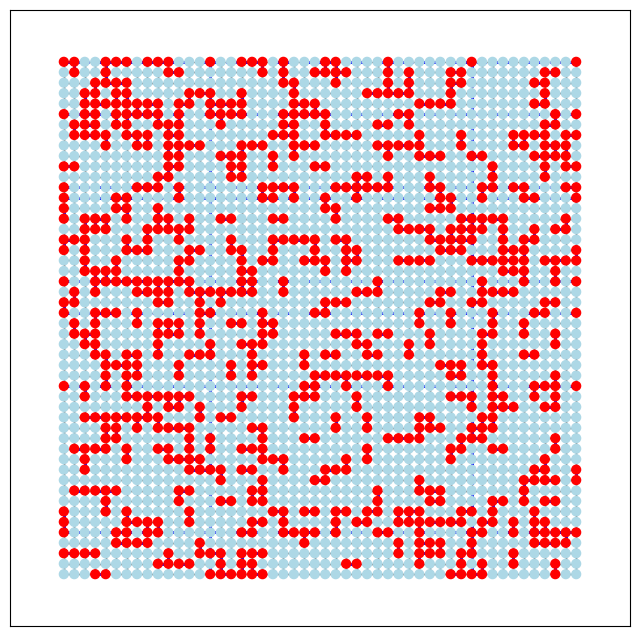

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random

random.seed(42)


rows, cols = 50, 50
q = 0.1 # fraction of edges to remove


G = nx.grid_2d_graph(rows, cols, periodic=True)
mapping = {(i, j): i * cols + j for i in range(rows) for j in range(cols)}
G = nx.relabel_nodes(G, mapping)

edges = list(G.edges())
num_remove = int(q * len(edges))
edges_to_remove = random.sample(edges, num_remove)
G.remove_edges_from(edges_to_remove)

# List the removed edges
#print("Removed edges:")
#for edge in edges_to_remove:
 #   print(edge)


node_color = ['red' if G.degree[n] < 4 else 'lightblue' for n in G.nodes()]


pos = {n: (n % cols, - (n // cols)) for n in G.nodes()}


remaining_edges = list(G.edges())
removed_edges_set = set(edges_to_remove)

plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=40)
nx.draw_networkx_edges(G, pos, edgelist=remaining_edges, edge_color='gray')
nx.draw_networkx_edges(G, pos, edgelist=edges_to_remove, edge_color='blue', style='dashed', width=2)
#nx.draw_networkx_labels(G, pos, font_size=8)


#plt.title("")
plt.axis("equal")
plt.show()

Check to see if the graph is connected (A irreducible)

In [ ]:
import networkx as nx


if nx.is_connected(G):
    print("The graph is connected → adjacency matrix is irreducible.")
else:
    print("The graph is NOT connected → adjacency matrix is reducible.")


The graph is connected → adjacency matrix is irreducible.


Code to compute eigenvalues and eigenvectors of the adjacency matrix A of the above graph G, to select the largest eigenvalue with correspondant eigenvector and compute the square of each component. This to have the stationary distribution of a maximal entropy random walk on it.

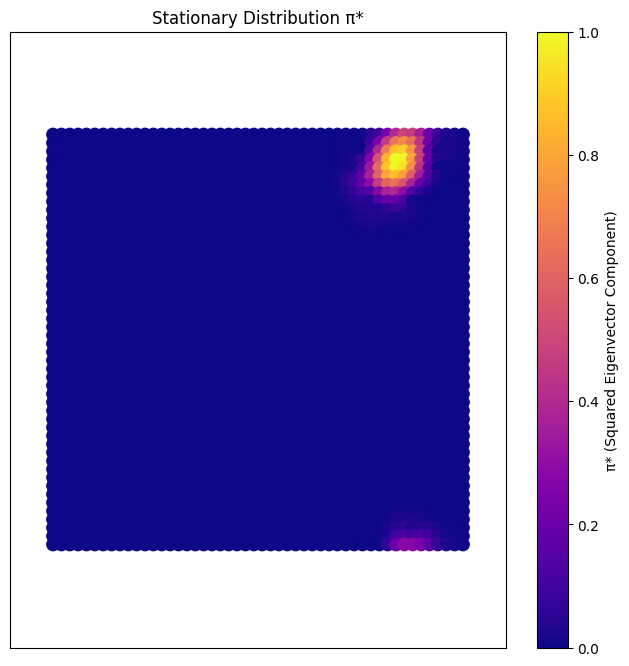

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse.linalg import eigs
from scipy.sparse import csr_matrix


A_sparse = nx.to_scipy_sparse_array(G, format='csr', dtype=float)


eigval, eigvec = eigs(A_sparse, k=1, which='LR')
v = np.real(eigvec[:, 0])
v = np.abs(v)
v /= np.linalg.norm(v)


v_squared = v ** 2
v_squared_norm = (v_squared - np.min(v_squared)) / (np.max(v_squared) - np.min(v_squared))


pos = {n: (n % cols, - (n // cols)) for n in G.nodes()}

ì
plt.figure(figsize=(8, 8))
nodes = nx.draw_networkx_nodes(G, pos, node_color=v_squared_norm, cmap='plasma', node_size=80)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=1)
plt.title("Stationary Distribution π*")
plt.axis('equal')
plt.colorbar(nodes, label='π* (Squared Eigenvector Component)')
plt.show()

# **Now this is the code to analyse the real network of products co-purchasing of amazon**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Number of nodes: 262,111
Number of edges: 1,234,877
Average degree: 9.42
Is strongly connected? False
Number of strongly connected components: 6594


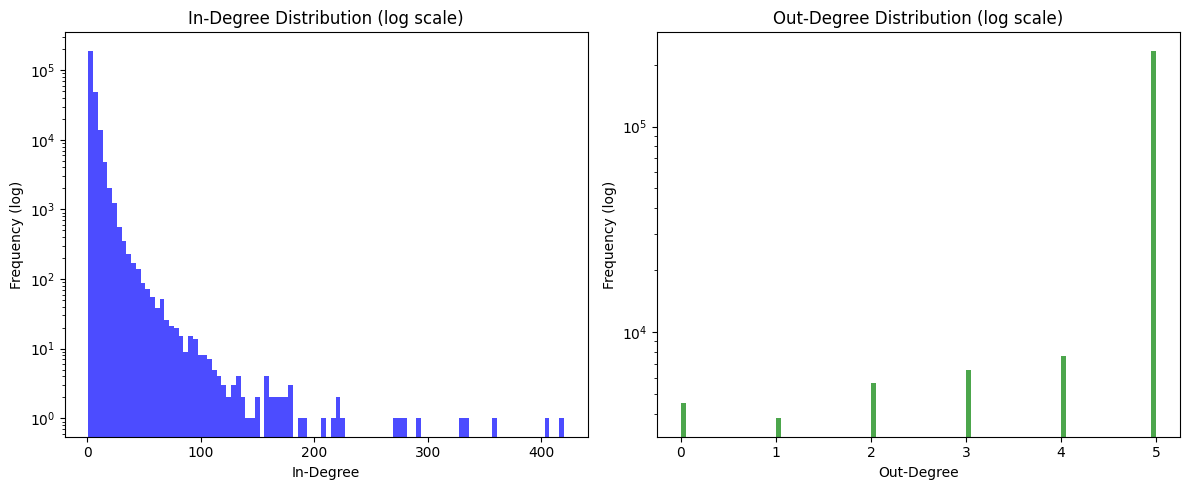

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


file_path = "/content/drive/MyDrive/Complex_Networks/Amazon0302.txt"


G = nx.read_edgelist(
    file_path,
    delimiter='\t',
    comments='#',
    create_using=nx.DiGraph(),
    nodetype=int
)


print(f"Number of nodes: {G.number_of_nodes():,}")
print(f"Number of edges: {G.number_of_edges():,}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
print(f"Is strongly connected? {nx.is_strongly_connected(G)}")
print(f"Number of strongly connected components: {nx.number_strongly_connected_components(G)}")


in_degrees = [d for _, d in G.in_degree()]
out_degrees = [d for _, d in G.out_degree()]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=100, log=True, color='blue', alpha=0.7)
plt.title("In-Degree Distribution (log scale)")
plt.xlabel("In-Degree")
plt.ylabel("Frequency (log)")

plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=100, log=True, color='green', alpha=0.7)
plt.title("Out-Degree Distribution (log scale)")
plt.xlabel("Out-Degree")
plt.ylabel("Frequency (log)")

plt.tight_layout()
plt.show()


Since the graph is not strongly connected, I'm gonna separate the largest strongly connected components and analyse it.


Number of strongly connected components: 6594
Size of largest strongly connected component: 241761
Nodes in SCC: 241761
Edges in SCC: 1131217
Average degree: 9.36
Is strongly connected? True


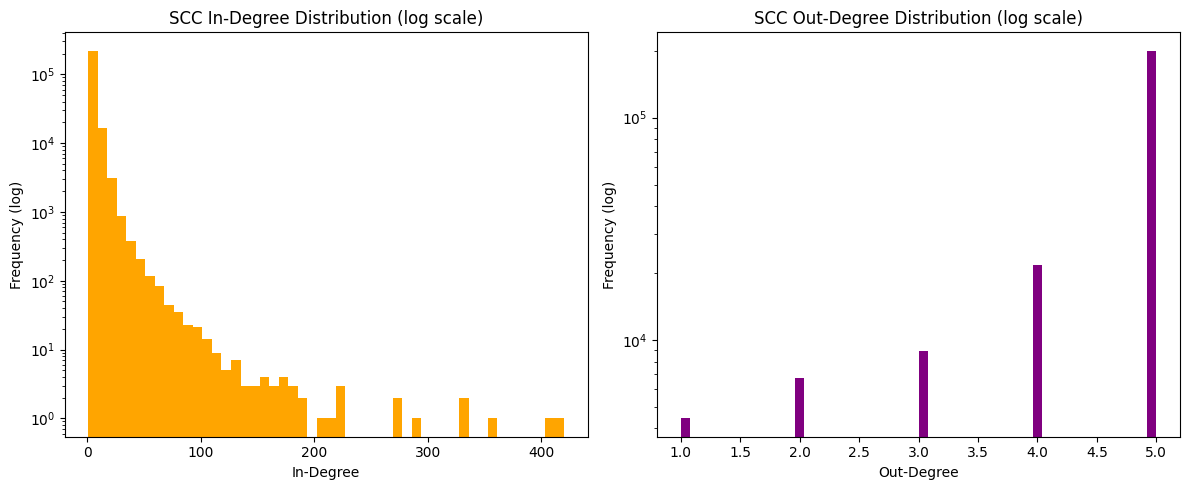

In [ ]:

sccs = list(nx.strongly_connected_components(G))
largest_scc = max(sccs, key=len)

print(f"Number of strongly connected components: {len(sccs)}")
print(f"Size of largest strongly connected component: {len(largest_scc)}")

G_scc = G.subgraph(largest_scc).copy()


print(f"Nodes in SCC: {G_scc.number_of_nodes()}")
print(f"Edges in SCC: {G_scc.number_of_edges()}")
print(f"Average degree: {sum(dict(G_scc.degree()).values()) / G_scc.number_of_nodes():.2f}")
print(f"Is strongly connected? {nx.is_strongly_connected(G_scc)}")


in_degrees = [d for _, d in G_scc.in_degree()]
out_degrees = [d for _, d in G_scc.out_degree()]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=50, log=True, color='orange')
plt.title("SCC In-Degree Distribution (log scale)")
plt.xlabel("In-Degree")
plt.ylabel("Frequency (log)")

plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=50, log=True, color='purple')
plt.title("SCC Out-Degree Distribution (log scale)")
plt.xlabel("Out-Degree")
plt.ylabel("Frequency (log)")

plt.tight_layout()
plt.show()

## **MERW**

Now, I would like to see a phenomen of localization on the network. This code is just to see the stationary distribution among nodes. On the x axis of the graph one can see all the nodes of the largest SCC ordered from rank 1 (the node with highest probability density) till the last rank. We can see from the distribution few nodes have a high probability distribution and then there is a dramatic decrease.

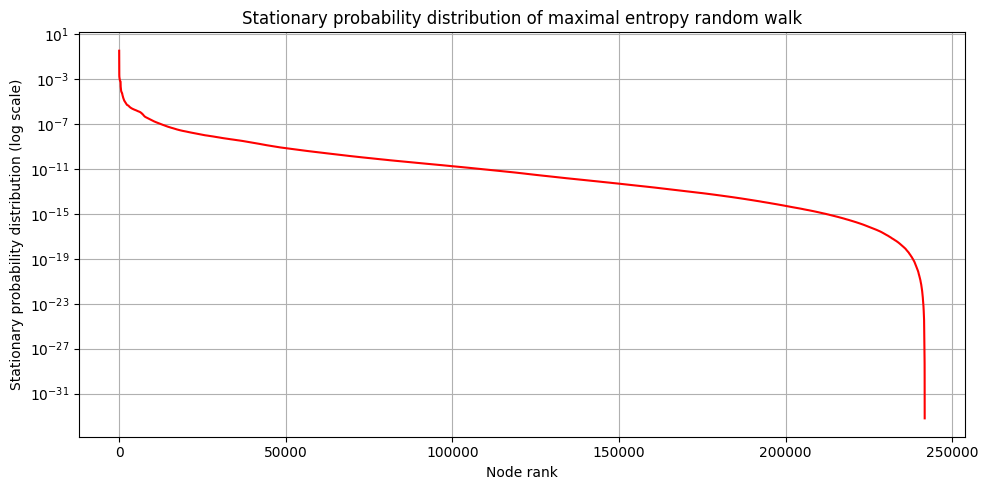

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh


G_undir = G_scc.to_undirected()

A_sparse = nx.to_scipy_sparse_array(G_undir, format='csr', dtype=float)


lambda_max, psi = eigsh(A_sparse, k=1, which='LA')

psi = psi[:, 0]
psi /= np.linalg.norm(psi)
pi_merw = psi**2
pi_merw /= pi_merw.sum()



plt.figure(figsize=(10, 5))
plt.plot(np.sort(pi_merw)[::-1], c='red')
plt.yscale('log')
plt.title("Stationary probability distribution of maximal entropy random walk")
plt.xlabel("Node rank")
plt.ylabel("Stationary probability distribution (log scale)")
plt.grid(True)
plt.tight_layout()
plt.show()


Top nodes by π_merw: [4429, 2501, 2353, 4697, 5120]


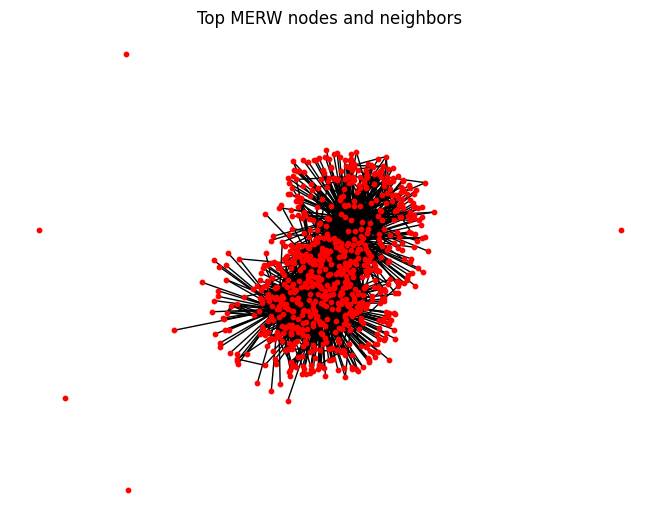

In [ ]:
top_k = np.argsort(-pi_merw)[:5]  #sort indices of pi_merw from largest to smaller and select fisrt 5
print("Top nodes by π_merw:", [list(G_undir.nodes())[i] for i in top_k])
sub_nodes = set(top_k)
for node in top_k:
    sub_nodes.update(G_undir.neighbors(list(G_undir.nodes())[node]))
H = G_undir.subgraph(sub_nodes)

pos = nx.spring_layout(H)
nx.draw(H, pos, with_labels=False, node_color='red', node_size = 10)
plt.title("Top MERW nodes and neighbors")
plt.show()


In [ ]:
top_k = np.argsort(-pi_merw)[:10]
nodes = list(G_undir.nodes())

for i in top_k:
    node = nodes[i]
    deg = G_undir.degree(node)
    print(f"Node: {node}, πᵢ: {pi_merw[i]:.5f}, degree: {deg}")


Node: 4429, πᵢ: 0.32640, degree: 405
Node: 2501, πᵢ: 0.03821, degree: 194
Node: 2353, πᵢ: 0.03040, degree: 180
Node: 4697, πᵢ: 0.01982, degree: 91
Node: 5120, πᵢ: 0.01951, degree: 95
Node: 5121, πᵢ: 0.01943, degree: 103
Node: 5735, πᵢ: 0.01059, degree: 81
Node: 4431, πᵢ: 0.00950, degree: 65
Node: 6677, πᵢ: 0.00595, degree: 66
Node: 5190, πᵢ: 0.00583, degree: 49


## Rimossione del nodo 4429 a cui corrisponde un valore di MERW fuori dagli ordini di grandezza degli altri nodi

In [ ]:
# Trovo l'indice del nodo con MERW massimo
max_index = np.argmax(pi_merw)
nodes = list(G_undir.nodes())
node_to_remove = nodes[max_index]

print(f"Rimuovo il nodo con MERW massimo: {node_to_remove} (πᵢ = {pi_merw[max_index]:.5f})")

# Creo una copia del grafo e rimuovo il nodo
G_removed = G_undir.copy()
G_removed.remove_node(node_to_remove)

#lo tolgo anche dall'array di pi_merw
pi_merw_removed = np.delete(pi_merw, max_index)

# Verifico
print(f"Numero di nodi originale: {G_undir.number_of_nodes()}")
print(f"Numero di nodi dopo rimozione: {G_removed.number_of_nodes()}")

Rimuovo il nodo con MERW massimo: 4429 (πᵢ = 0.32640)
Numero di nodi originale: 241761
Numero di nodi dopo rimozione: 241760


Now i want to start to see if the nodes with higher stationary probability are also part of 'regular' zones. In the following by 'regular' i'll mean surrounded by nodes with similar degree, i.e. with a low degree variance

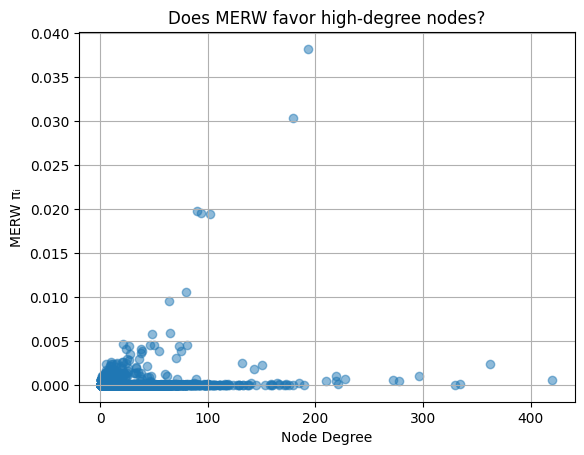

In [ ]:
degrees = np.array([G_removed.degree(n) for n in G_removed.nodes()])
plt.scatter(degrees, pi_merw_removed, alpha=0.5)
plt.xlabel("Node Degree")
plt.ylabel("MERW πᵢ")
plt.title("Does MERW favor high-degree nodes?")
plt.grid(True)
plt.show()


## **Local degree entropy**


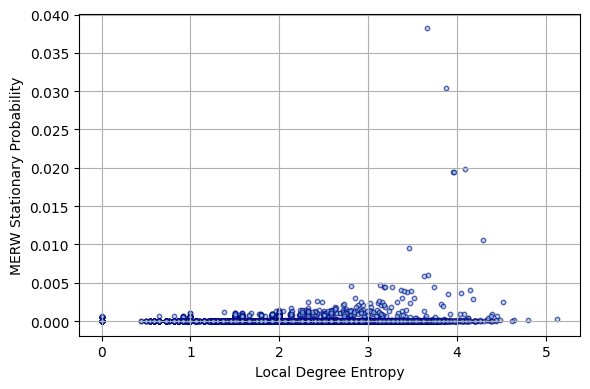

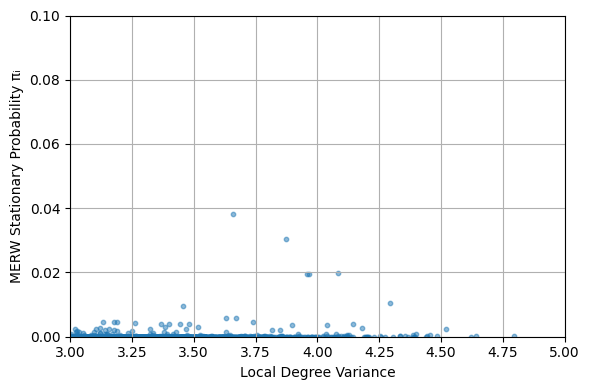

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def local_degree_entropy(G, node):
    neighbors = list(G.neighbors(node))
    if not neighbors:
        return 0
    neighbor_degrees = [G.degree(n) for n in neighbors]
    counts = Counter(neighbor_degrees)
    probs = np.array(list(counts.values())) / len(neighbor_degrees)
    return -np.sum(probs * np.log2(probs))


local_entropy = np.array([local_degree_entropy(G_removed, n) for n in G_removed.nodes()])


plt.figure(figsize=(6, 4))
plt.scatter(local_entropy, pi_merw_removed, alpha=0.6, s=10, c='skyblue', edgecolors='navy')
plt.xlabel("Local Degree Entropy")
plt.ylabel("MERW Stationary Probability")
#plt.title("MERW vs Local Degree Entropy")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(local_entropy, pi_merw_removed, alpha=0.5, s=10)
plt.xlabel("Local Degree Variance")
plt.ylabel("MERW Stationary Probability πᵢ")
#plt.title("Zoom: MERW vs Local Regularity")
plt.grid(True)
plt.ylim(0, 0.10)
plt.xlim(3, 5)  # adjust as needed
plt.tight_layout()
plt.show()



## **Local clustering coefficient**

Now, i repeat the same analysis but using the local clustering coefficient as criterion for 'regularity'

In [ ]:
clustering_dict = nx.clustering(G_removed)
clustering = np.array([clustering_dict[n] for n in G_removed.nodes()])


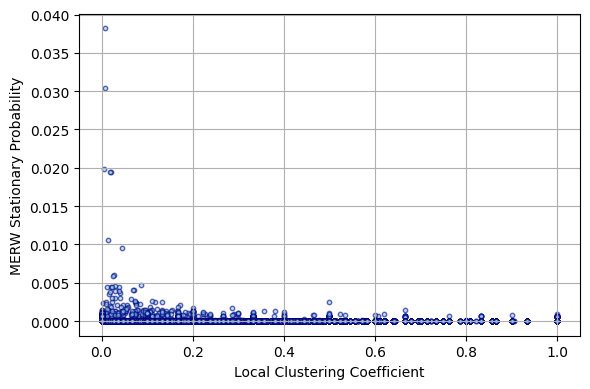

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(clustering, pi_merw_removed, alpha=0.6, s=10, c='skyblue', edgecolors='navy')
plt.xlabel("Local Clustering Coefficient")
plt.ylabel("MERW Stationary Probability")
#plt.title("MERW vs Local Clustering")
plt.grid(True)
plt.tight_layout()
plt.show()


## **Degree centrality**

In [ ]:
deg_centrality_dict = nx.degree_centrality(G_removed)
deg_centrality = np.array([deg_centrality_dict[n] for n in G_removed.nodes()])


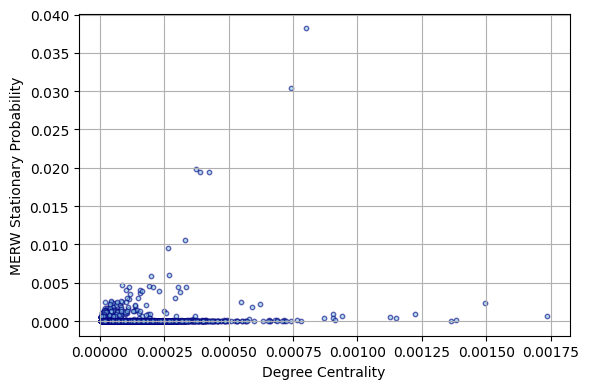

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(deg_centrality, pi_merw_removed, alpha=0.6, s=10, c='skyblue', edgecolors='navy')
plt.xlabel("Degree Centrality")
plt.ylabel("MERW Stationary Probability")
#plt.title("MERW vs Local Clustering")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Betweenness Centrality**

In [ ]:
betweenness_dict = nx.betweenness_centrality(G_removed)
betweenness = np.array([betweenness_dict[n] for n in G_removed.nodes()])


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(deg_centrality, pi_merw_removed, alpha=0.6, s=10, c='skyblue', edgecolors='navy')
plt.xlabel("Degree Centrality")
plt.ylabel("MERW Stationary Probability")
#plt.title("MERW vs Local Clustering")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Closeness Centrality**

In [ ]:
closeness_dict = nx.closeness_centrality(G_removed)
closeness = np.array([closeness_dict[n] for n in G_removed.nodes()])

KeyboardInterrupt: 

## **Katz centrality**

In [ ]:
katz_centrality_dict = nx.katz_centrality_numpy(G_removed, alpha=0.01)
katz_centrality = np.array([katz_centrality_dict[n] for n in G_removed.nodes()])

## **Correlazione tra misure di centralità e MERW**

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

nodes = list(G_removed.nodes())

# 1️⃣ Degree centrality
degree_centrality = nx.degree_centrality(G_removed)
degree_vals = np.array([degree_centrality[n] for n in nodes])

# 2️⃣ Local clustering coefficient
clustering = nx.clustering(G_removed)
clustering_vals = np.array([clustering[n] for n in nodes])


# 5️⃣ MERW stationary distribution (pi_merw) già calcolato
merw_vals = np.array(pi_merw_removed)

# Organizza i dati in un dizionario
centralities = {
    "MERW": merw_vals,
    "Degree": degree_vals,
    "Clustering": clustering_vals
}

# Calcola correlazioni Pearson tra MERW e ciascuna misura
correlations = {}
for name, vals in centralities.items():
    if name != "MERW":  # MERW vs ciascuna centralità
        corr, _ = pearsonr(merw_vals, vals)
        correlations[name] = corr

# Mostra risultati in un DataFrame
results_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Pearson correlation with MERW'])
results_df


,Pearson correlation with MERW
Degree,0.151463
Clustering,-0.022191
